In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [ ]:
# Load DataFrame and filter records for 2010 onwards for Brazil, Vietnam, United States, Tanzania and Papua New Guinea
df = pd.read_csv(f'psd_coffee.csv')
df_filtered = df[df['Country'].isin(['Brazil', 'Vietnam', 'United States', 'Tanzania', 'Switzerland']) & (df['Year'] >= 2002)]
df_filtered.head()

In [ ]:
# Split into training and test data. Training data is for the first 10 years, while test data is the final 3 years in the series
df_train = df_filtered[(df_filtered['Year'] >= 2002) & (df_filtered['Year'] < 2020)]
df_test = df_filtered[df_filtered['Year'] >= 2020]
X_train = df_train.drop(['Other Production', 'Total Distribution', 'Exports'], axis=1)
y_train = df_train['Exports']
X_test = df_test.drop(['Other Production', 'Total Distribution', 'Exports'], axis=1)
y_test = df_test['Exports']

In [ ]:
X_train.columns

In [ ]:
# Plot distribution of input variables for Brazil
def plot_country_input_distribution(country:str, color:str):
    X_train_country = X_train[X_train['Country'] == country]
    for i in range(len(X_train_country.columns[2:])):
        plt.figure(figsize=(12,50))
        ax = plt.subplot(len(X_train_country.columns), 1, i + 1)
        sns.lineplot(x=X_train_country['Year'], y=X_train_country.iloc[:, 2 + i], color=color)
        plt.title(f'{X_train.columns[2 + i]} by Year')
        plt.xlabel('Year')
        plt.ylabel(f'{X_train.columns[2+i]}')
        plt.show()
plot_country_input_distribution(country='Brazil', color='Blue')

In [ ]:
# Plot Distribution of exports
def plot_distribution_of_exports(country:str, color:str):
    plt.figure(figsize=(8,4))
    sns.lineplot(x='Year', y='Exports', data=df_train[df_train['Country'] == country], color=color)
    plt.xlabel('Year')
    plt.ylabel('Exports')
    plt.title(f'Exports by Year in {country}')
    plt.show()
plot_distribution_of_exports(country='Brazil', color='Blue')

In [ ]:
# Plot distribution of input variables for Vietnam
plot_country_input_distribution(country='Vietnam', color='Red')

In [ ]:
# Plot distribution of exports for Vietnam
plot_distribution_of_exports(country='Vietnam', color='Red')

In [ ]:
# Plot distribution of input variables for United States
plot_country_input_distribution(country='United States', color='Black')

In [ ]:
# Plot distribution of exports for United States
plot_distribution_of_exports(country='United States', color='Black')

In [ ]:
# Plot distribution of input variables for Tanzania
plot_country_input_distribution(country='Tanzania', color='Yellow')

In [ ]:
# Plot distribution of exports for Tanzania
plot_distribution_of_exports(country='Tanzania', color='Yellow')

In [ ]:
# Plot distribution of input variables for Switzerland
plot_country_input_distribution(country='Switzerland', color='Green')

In [ ]:
# Plot distribution of exports for Switzerland
plot_distribution_of_exports(country='Switzerland', color='Green')

In [ ]:
# Generate partial autocorrelation plots for exports in each country
countries = df_train['Country'].unique()
for country in countries:
    country_df = df_train[df_train['Country'] == country]
    country_df = country_df.set_index('Year')
    plt.figure(figsize=(8,4))
    plot_acf(country_df['Exports'], lags=8, title=f'Autocorrelation for {country}')
    plot_pacf(country_df['Exports'], lags=8, title=f'Partial Autocorrelation for {country}')
    plt.show()

In [ ]:
# Fit a ARIMA model using one day lag as baseline prediction
for country in countries:
    X_baseline_train = df_train[df_train['Country'] == country][['Year', 'Exports']]
    X_baseline_train['Year'] = pd.to_datetime(X_baseline_train['Year'], format='%Y')
    X_baseline_train.set_index('Year', inplace=True)
    X_baseline_test = df_test[df_test['Country'] == country][['Year', 'Exports']]
    X_baseline_test['Year'] = pd.to_datetime(X_baseline_test['Year'], format='%Y')
    X_baseline_test.set_index('Year', inplace=True)
    forecasts = []
    actuals = []
    # Initialize the model
    model = ARIMA(X_baseline_train, order=(1,0,0))
    # Iterate over each step in the test set
    for i in range(len(X_baseline_test)):
        # Fit the model with data up to the current step
        model_fit = model.fit()
        
        # Forecast one step ahead
        forecast = model_fit.forecast(steps=1)[0]
        
        # Append the forecast to the list of forecasts
        forecasts.append(forecast)
        
        # Get the actual value for comparison
        actual = X_baseline_test.iloc[i]['Exports']
        
        # Append the actual value to the list of actual values
        actuals.append(actual)
        
        # Update the model with the latest data point
        model = ARIMA(np.append(X_baseline_train['Exports'], actual), order=(1,0,0))
        
    # Plot the forecasts against the actual values
    plt.figure(figsize=(10, 6))
    plt.plot(X_baseline_test.index, actuals, label='Actual')
    plt.plot(X_baseline_test.index, forecasts, color='red', linestyle='--', label='Forecast')
    plt.xlabel('Year')
    plt.ylabel('Exports')
    plt.title(f'Rolling Forecast vs Actual Exports for {country}')
    plt.legend()
    plt.show()
    
    # Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(actuals, forecasts)
    print('Mean Absolute Error (MAE) for', country, ':', mae)

/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rou

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05602D+01    |proj g|=  2.50873D+12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   2.509D+12  -1.056D+01
  F =  -10.560223453190449     

ABNORMAL_TERMINATION_IN_LNSRCH                              


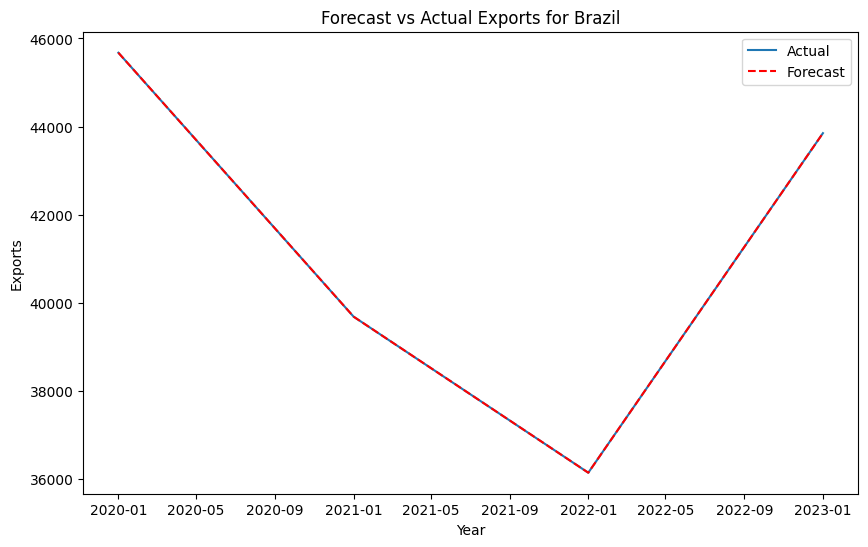

Mean Absolute Error (MAE): 1.8189894035458565e-12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05940D+01    |proj g|=  3.27106D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   3.271D+10  -1.059D+01
  F =  -10.593986931765556     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

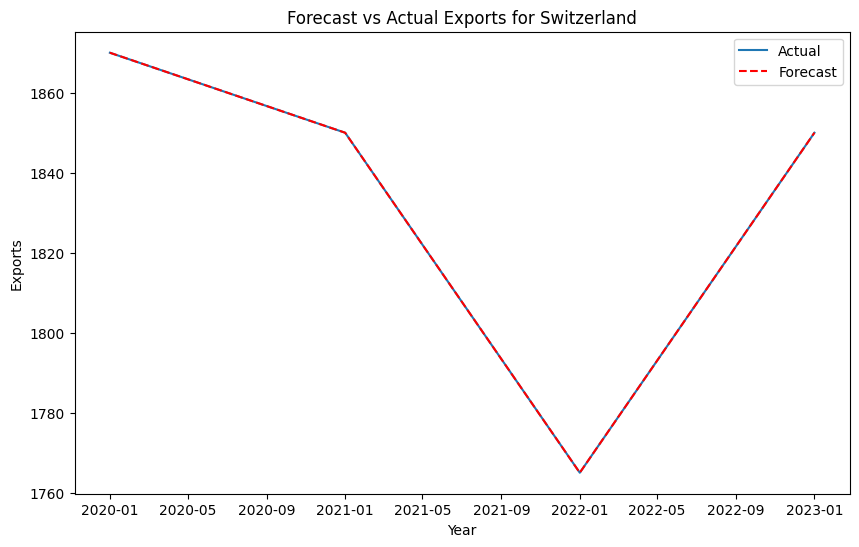

Mean Absolute Error (MAE): 1.1368683772161603e-12
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05246D+01    |proj g|=  2.83191D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   2.832D+09  -1.052D+01
  F =  -10.524604414537132     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rou

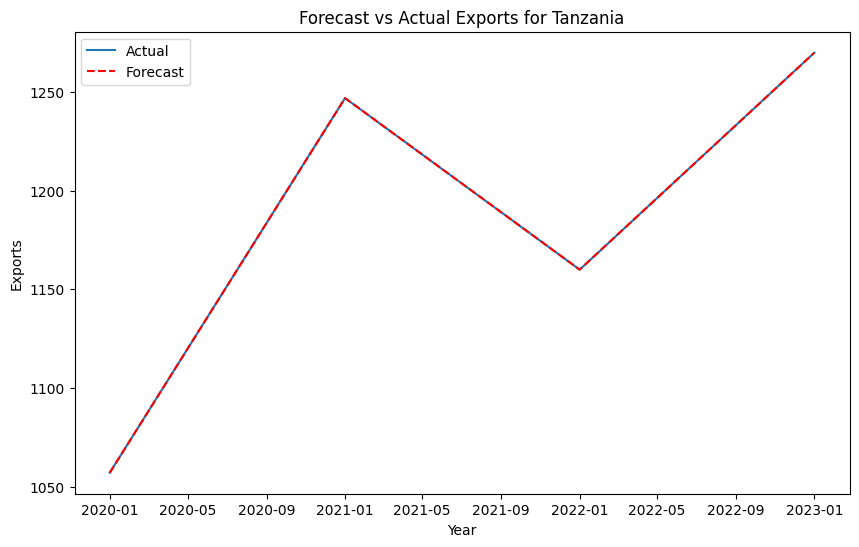

Mean Absolute Error (MAE): 0.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05533D+01    |proj g|=  1.15648D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.156D+09  -1.055D+01
  F =  -10.553279232354269     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rou

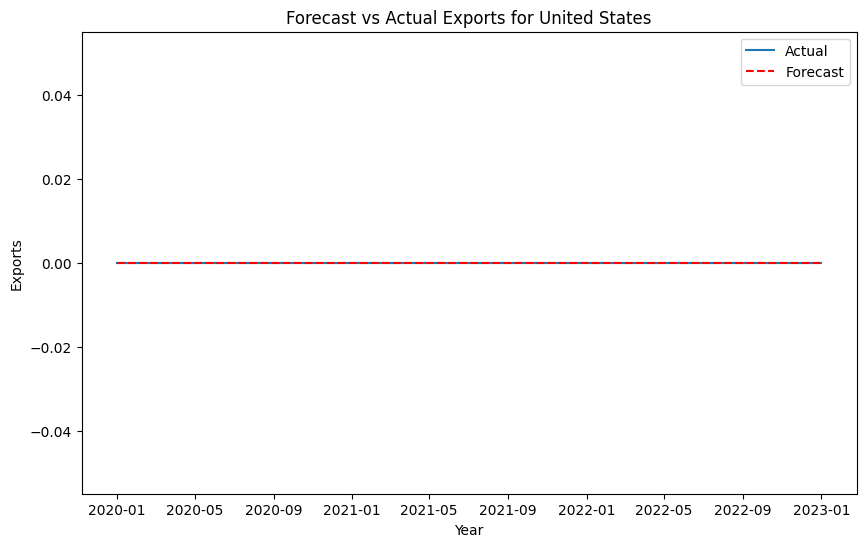

Mean Absolute Error (MAE): 0.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05301D+01    |proj g|=  6.97503D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   6.975D+11  -1.053D+01
  F =  -10.530100587550002     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/Users/kpali/Documents/ML/Coffee-Kaggle/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rou

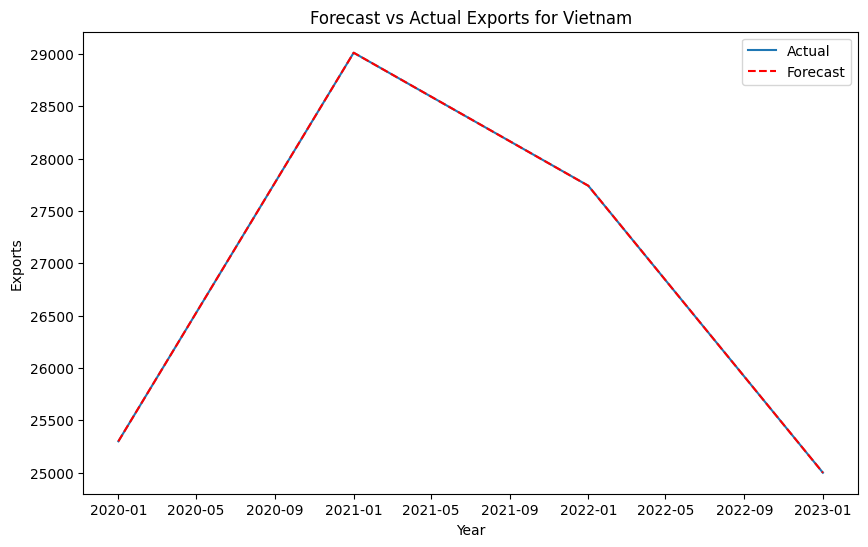

Mean Absolute Error (MAE): 6.366462912410498e-12


In [44]:
# Fit a SARIMAX model using one day lag and bean exports, soluble exports, and roast and ground exports as baseline prediction
for country in countries:
    X_train = df_train[df_train['Country'] == country][['Year', 'Exports', 'Bean Exports', 'Soluble Exports', 'Roast & Ground Exports']]
    X_train['Year'] = pd.to_datetime(X_train['Year'], format='%Y')
    X_train.set_index('Year', inplace=True)
    
    exog_train = X_train[['Bean Exports', 'Soluble Exports', 'Roast & Ground Exports']]
    endog_train = X_train['Exports']
    
    model = SARIMAX(endog=endog_train, exog=exog_train, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit()
    
    X_test = df_test[df_test['Country'] == country][['Year', 'Exports', 'Bean Exports', 'Soluble Exports', 'Roast & Ground Exports']]
    X_test['Year'] = pd.to_datetime(X_test['Year'], format='%Y')
    X_test.set_index('Year', inplace=True)
    
    exog_test = X_test[['Bean Exports', 'Soluble Exports', 'Roast & Ground Exports']]
    endog_test = X_test['Exports']
    
    forecast = model_fit.forecast(steps=len(X_test), exog=exog_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(X_test.index, endog_test, label='Actual')
    plt.plot(X_test.index, forecast, color='red', linestyle='--', label='Forecast')
    plt.xlabel('Year')
    plt.ylabel('Exports')
    plt.title(f'Forecast vs Actual Exports for {country}')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(endog_test, forecast)
    print('Mean Absolute Error (MAE):', mae)